In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import calculate_log as callog
%matplotlib inline

In [2]:
class opt:
    outf = 'extracted_features'
    backbone_name = 'resnet18_vanilla_simclr_svhn'
    dataset ='svhn'

In [3]:
ood_dataset=['cifar10','cifar100', 'lsun_resize','imagenet_resize','lsun_fix','imagenet_fix','place365','dtd']
out_dataset=ood_dataset
num_out_datasets = 8

In [4]:
ind_dataset= opt.dataset
experiment = opt.backbone_name
ae_type = 'sigmoid_AE'
prefix = 'confidence' #confidence

layer_num=9
epoch=500
ind=[]
ind_train=[]
ood=dict()
for i in range(layer_num):
    ood[i]=[]
    ind.append(np.loadtxt(os.path.join('trained_autoencoders',ae_type,experiment,'{}_layer_{}_in_{}_epoch_{}.txt'.format(prefix, i,ind_dataset,epoch))))
    ind_train.append(np.loadtxt(os.path.join('trained_autoencoders',ae_type,experiment,'{}_layer_{}_in_{}_epoch_{}_train.txt'.format(prefix, i,ind_dataset,epoch))))
    for j in range(len(ood_dataset)):
        ood[i].append(np.loadtxt(os.path.join('trained_autoencoders',ae_type,experiment,'{}_layer_{}_out_{}_epoch_{}_model1.txt'.format(prefix, i,ood_dataset[j],epoch))))

# ind_MD = np.load(os.path.join('/HDD0','ParkYH','deep_Mahalanobis_detector','output_features',ind_dataset,'Mahalanobis_in_{}_original_single.npy'.format(ind_dataset)))[:,:-1]
# ood_MD=[]
# for j in range(len(ood_dataset)):
#     ood_MD.append(np.load(os.path.join('/HDD0','ParkYH','deep_Mahalanobis_detector','output_features',ind_dataset,'Mahalanobis_out_{}_original_single.npy'.format(ood_dataset[j])))[:,:-1])

In [5]:
train_ind_feature=dict()
test_ind_feature=dict()
test_ood_feature=dict()
num_ood=dict()

for i in range(layer_num):
    test_ood_feature[i]=[]
    num_ood[i]=[]
    train_ind_feature[i]=np.load(os.path.join(opt.outf,opt.backbone_name,'Features_from_layer_'+str(i)+'_'+opt.dataset+'_'+'original'+'_train_ind.npy'))
    test_ind_feature[i]=np.load(os.path.join(opt.outf,opt.backbone_name,'Features_from_layer_'+str(i)+'_'+opt.dataset+'_'+'original'+'_test_ind.npy'))
    print(num_out_datasets)
    for j in range(num_out_datasets):
        test_ood_feature[i].append(np.load(os.path.join(opt.outf,opt.backbone_name,'Features_from_layer_'+str(i)+'_'+out_dataset[j]+'_'+'original'+'_test_ood.npy')))
        num_ood[i].append(test_ood_feature[i][j].shape[0])
train_data_ind = train_ind_feature
test_data_ind = test_ind_feature
test_data_ood = test_ood_feature
for i in range(layer_num):
    print(train_data_ind[i].shape)

8
8
8
8
8
8
8
8
8
(73257, 64)
(73257, 64)
(73257, 64)
(73257, 128)
(73257, 128)
(73257, 256)
(73257, 256)
(73257, 512)
(73257, 512)


In [6]:
train_ind_norm=dict()
test_ind_norm=dict()
test_ood_norm=dict()

layer = layer_num - 1
for i in range(layer_num):
    #layer=i
    #layer=layer_num-1
    test_ood_norm[i]=[]
    num_ood[i]=[]
    train_ind_norm[i]=np.linalg.norm(train_ind_feature[layer],axis=1)
    test_ind_norm[i]=np.linalg.norm(test_ind_feature[layer],axis=1)
    print(num_out_datasets)
    for j in range(num_out_datasets):
        test_ood_norm[i].append(np.linalg.norm(test_ood_feature[layer][j],axis=1))


# norm_train_ind = train_ind_feature[13].norm(axis=1)

8
8
8
8
8
8
8
8
8


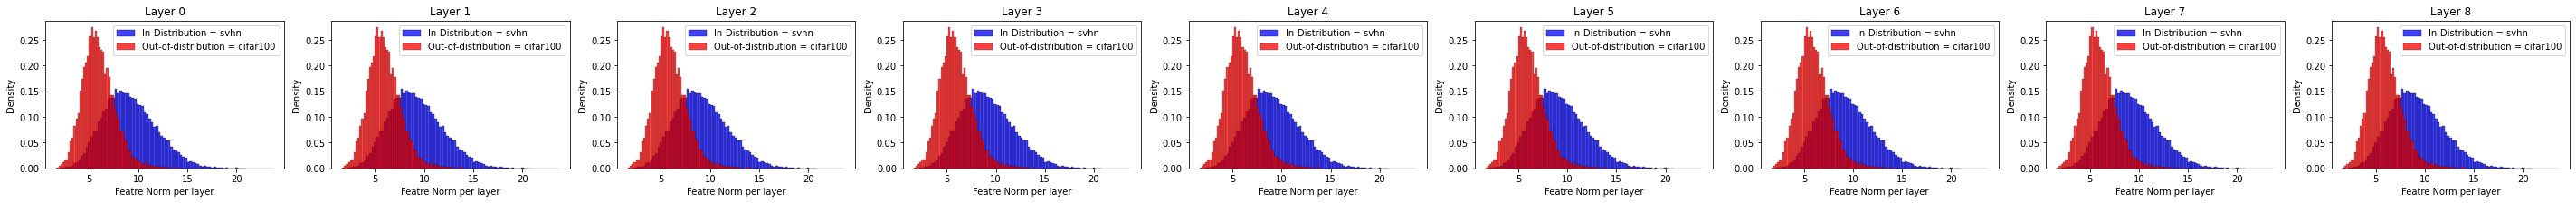

In [7]:
ood_index=1
fig,axs=plt.subplots(1,layer_num,figsize=(50,3))
results=dict()
for layer in range(layer_num):
    sns.histplot(ax=axs[layer],data=test_ind_norm[layer],color='blue',stat='density')
    sns.histplot(ax=axs[layer],data=test_ood_norm[layer][ood_index],color='red',stat='density')
    axs[layer].legend(['In-Distribution = {}'.format(ind_dataset),'Out-of-distribution = {}'.format(ood_dataset[ood_index])])
    axs[layer].set_title('Layer '+str(layer))
    axs[layer].set_xlabel('Featre Norm per layer')



In [8]:
ind_revised=[]
ind_train_revised=[]
ood_revised=dict()

for i in range(layer_num):
    ood_revised[i]=[]
    ind_revised.append(ind[i]/test_ind_norm[i])
    ind_train_revised.append(ind_train[i]/train_ind_norm[i])
    for j in range(len(ood_dataset)):
        ood_revised[i].append(ood[i][j]/test_ood_norm[i][j])

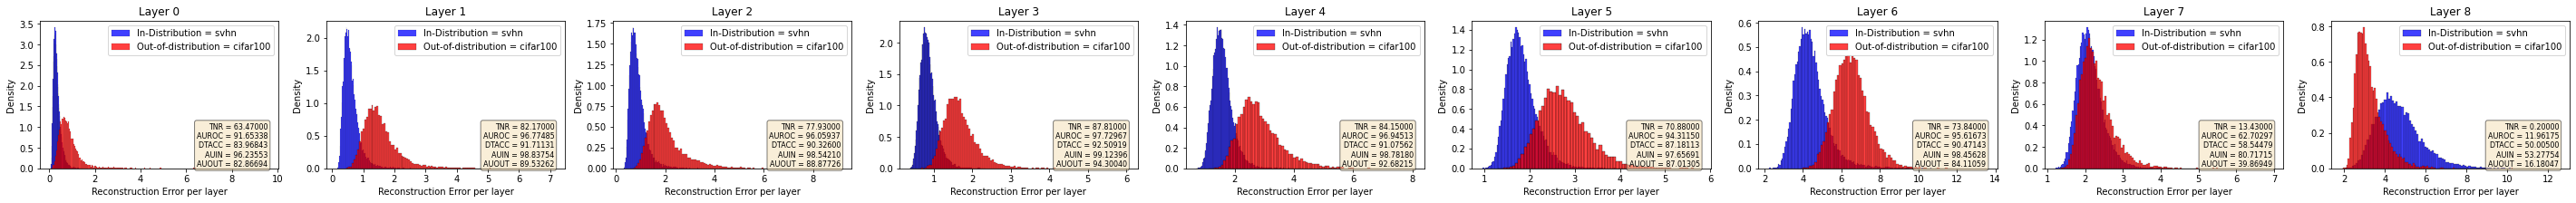

In [9]:
ood_index=1
fig,axs=plt.subplots(1,layer_num,figsize=(50,3))
results=dict()
for layer in range(layer_num):
    results[layer],_,_ = callog.metric(ind[layer],ood[layer][ood_index])
    sns.histplot(ax=axs[layer],data=-ind[layer],color='blue',stat='density')
    sns.histplot(ax=axs[layer],data=-ood[layer][ood_index],color='red',stat='density')
    axs[layer].legend(['In-Distribution = {}'.format(ind_dataset),'Out-of-distribution = {}'.format(ood_dataset[ood_index])])
    axs[layer].set_title('Layer '+str(layer))
    axs[layer].set_xlabel('Reconstruction Error per layer')

    rst = results[layer]['TMP']
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    metric = 'TNR = {:.5f}\nAUROC = {:.5f}\nDTACC = {:.5f}\nAUIN = {:.5f}\nAUOUT = {:.5f}'.format(100*rst['TNR'],100*rst['AUROC'],100*rst['DTACC'],100*rst['AUIN'],100*rst['AUOUT'])
    axs[layer].text(np.max((np.max(-ind[layer]),np.max(-ood[layer][ood_index]))),0, metric, fontsize=8,horizontalalignment='right', verticalalignment='bottom', bbox=props)



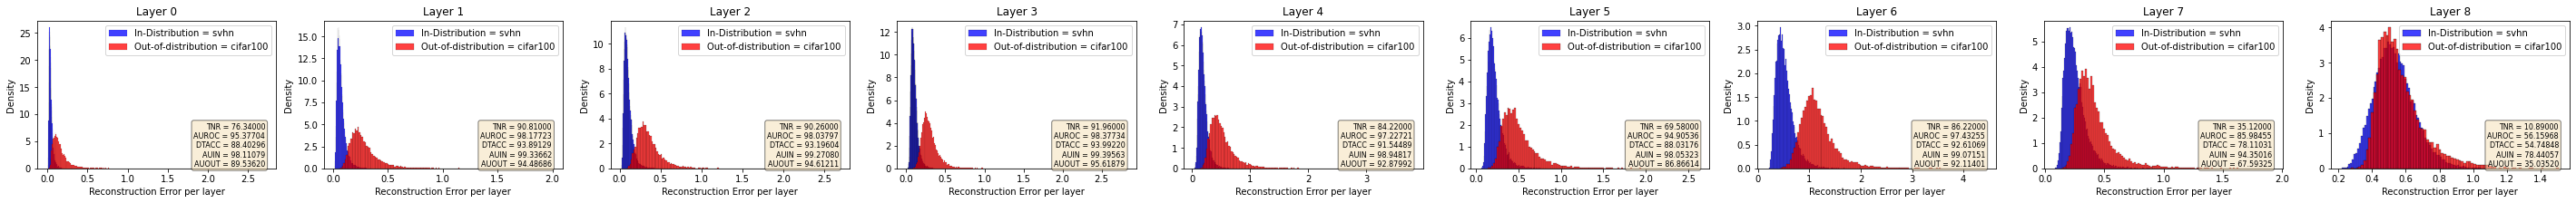

In [10]:
ood_index=1
fig,axs=plt.subplots(1,layer_num,figsize=(50,3))
results=dict()
for layer in range(layer_num):
    results[layer],_,_ = callog.metric(ind_revised[layer],ood_revised[layer][ood_index])
    sns.histplot(ax=axs[layer],data=-ind_revised[layer],color='blue',stat='density')
    sns.histplot(ax=axs[layer],data=-ood_revised[layer][ood_index],color='red',stat='density')
    axs[layer].legend(['In-Distribution = {}'.format(ind_dataset),'Out-of-distribution = {}'.format(ood_dataset[ood_index])])
    axs[layer].set_title('Layer '+str(layer))
    axs[layer].set_xlabel('Reconstruction Error per layer')

    rst = results[layer]['TMP']
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    metric = 'TNR = {:.5f}\nAUROC = {:.5f}\nDTACC = {:.5f}\nAUIN = {:.5f}\nAUOUT = {:.5f}'.format(100*rst['TNR'],100*rst['AUROC'],100*rst['DTACC'],100*rst['AUIN'],100*rst['AUOUT'])
    axs[layer].text(np.max((np.max(-ind_revised[layer]),np.max(-ood_revised[layer][ood_index]))),0, metric, fontsize=8,horizontalalignment='right', verticalalignment='bottom', bbox=props)




In [11]:
from sklearn.preprocessing import StandardScaler
ind_scaled=[]
ood_scaled=dict()
for j in range(len(ood_dataset)):
    ood_scaled[j]=[]

for i in range(layer_num):
    scaler=StandardScaler()
    scaler.fit(ind_train_revised[i].reshape(-1,1))
    ind_scaled.append(scaler.transform(ind_revised[i].reshape(-1,1)).reshape(-1))
    for j in range(len(ood_dataset)):
        ood_scaled[j].append(scaler.transform(ood_revised[i][j].reshape(-1,1)).reshape(-1))

In [12]:
ind_scaled_max=np.min(ind_scaled,0)
ood_scaled_max=[]
for j in range(len(ood_dataset)):
    ood_scaled_max.append(np.min(ood_scaled[j],0))

imagenet_fix
96.36 / 99.14 / 95.75


Text(136.8824885985385, 0, 'TNR = 96.36000\nAUROC = 99.13570\nDTACC = 95.75356\nAUIN = 99.68470\nAUOUT = 97.43671')

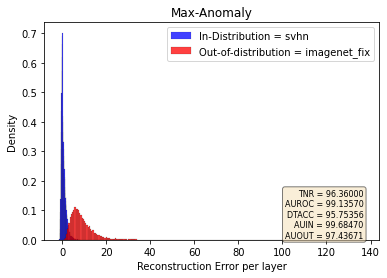

In [19]:
ood_index= 5
print(ood_dataset[ood_index])
results_max,_,_ = callog.metric(ind_scaled_max,ood_scaled_max[ood_index])
sns.histplot(data=-ind_scaled_max,color='blue',stat='density')
sns.histplot(data=-ood_scaled_max[ood_index],color='red',stat='density')
plt.legend(['In-Distribution = {}'.format(ind_dataset),'Out-of-distribution = {}'.format(ood_dataset[ood_index])])
plt.title('Max-Anomaly')
plt.xlabel('Reconstruction Error per layer')

rst = results_max['TMP']
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
metric = 'TNR = {:.5f}\nAUROC = {:.5f}\nDTACC = {:.5f}\nAUIN = {:.5f}\nAUOUT = {:.5f}'.format(100*rst['TNR'],100*rst['AUROC'],100*rst['DTACC'],100*rst['AUIN'],100*rst['AUOUT'])
print("{:.2f} / {:.2f} / {:.2f}".format(100*rst['TNR'],100*rst['AUROC'],100*rst['DTACC']))
plt.text(np.max((np.max(-ind_scaled_max),np.max(-ood_scaled_max[ood_index]))),0, metric, fontsize=8,horizontalalignment='right', verticalalignment='bottom', bbox=props)